In [1]:
%load_ext autoreload
%autoreload 2

# Graph aggregate statistics and select similar and dissimilar pairs

We will develop a similarity model for similar pairs; someone will review dissimilar pairs to find nicknames that we will incorporate later.

Note: I don't know why we call aggr-v2, but we will stick with it.

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import pandas as pd

from nama.data.filesystem import download_file_from_s3, save_file

In [3]:
# TODO do for both given and surname
given_surname = "given"
# given_surname = "surname"
Config = namedtuple("Config", "in_path min_freq similar_out_path dissimilar_out_path")
config = Config(
    in_path=f"s3://fs-nama-data/2024/familysearch-names/interim/tree-hr-{given_surname}-aggr-v2.parquet",
    min_freq = 20 if given_surname == "surname" else 5,
    similar_out_path=f"s3://fs-nama-data/2024/familysearch-names/processed/tree-hr-{given_surname}-similar.csv.gz",
    dissimilar_out_path=f"s3://fs-nama-data/2024/familysearch-names/processed/tree-hr-{given_surname}-dissimilar.csv.gz",
)

In [4]:
in_path = download_file_from_s3(config.in_path) if config.in_path.startswith("s3://") else config.in_path
df = pd.read_parquet(in_path)
print(df.shape)

(25541154, 10)


In [5]:
df.sample(n=10)

,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
818585,aline,ulysse,4,0,100062,182575,9867,3.997522e-05,2.078592e-05,0.333333
7478783,elizabeth,elijie,2,0,13294677,22318731,47,1.504362e-07,8.961065e-08,0.444444
23802568,ugertha,ugertha,6,6,10,22,22,6.000000e-01,3.750000e-01,1.000000
7905936,emilie,emede,2,0,449058,802670,318,4.453768e-06,2.490704e-06,0.500000
3185595,berniece,nonie,1,0,58547,111665,25693,1.708029e-05,7.280299e-06,0.375000
15611395,lucia,galliano,1,0,371869,665146,382,2.689119e-06,1.502569e-06,0.250000
3135203,bernard,diz,1,0,1523750,2455566,310,6.562756e-07,4.071869e-07,0.000000
12790743,jennesse,jenesse,4,2,154,216,120,2.597403e-02,1.818182e-02,0.875000
915348,almira,blanche,1,1,247667,379917,2514933,4.037679e-06,6.908826e-07,0.142857
10246254,giambattista,grovanbattisa,1,0,4368,8527,1,2.289377e-04,1.172745e-04,0.615385


In [6]:
# review low-frequency names
df[(df["total_name_frequency"] < 100) | (df["total_alt_name_frequency"] < 100)].sample(n=25)

,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
19104276,oline,mindrum,1,0,70033,135175,24,1.427898e-05,7.396559e-06,0.142857
6792312,doyles,daylas,1,0,97,231,32,1.030928e-02,3.816794e-03,0.666667
16040912,macedonia,maciconia,1,0,22687,40344,1,4.407811e-05,2.478683e-05,0.777778
17301543,matthaeus,marteinius,1,0,112000,170762,1,8.928571e-06,5.856104e-06,0.500000
531431,alavee,a,4,0,8,12,36295683,5.000000e-01,1.102059e-07,0.166667
24966127,willeroy,will,3,0,37,47,746099,8.108108e-02,4.020677e-06,0.500000
13814762,killekelly,killikelly,1,0,7,7,3,1.428571e-01,1.111111e-01,0.900000
15423339,louisa,livessa,1,0,2601883,4141960,9,3.843370e-07,2.414311e-07,0.428571
19444956,ottavina,ottarina,4,0,51,91,7,7.843138e-02,4.255319e-02,0.875000
1156865,amasa,amenson,1,0,44304,66982,8,2.257132e-05,1.492782e-05,0.428571


Text(0.5, 1.0, 'similarity')

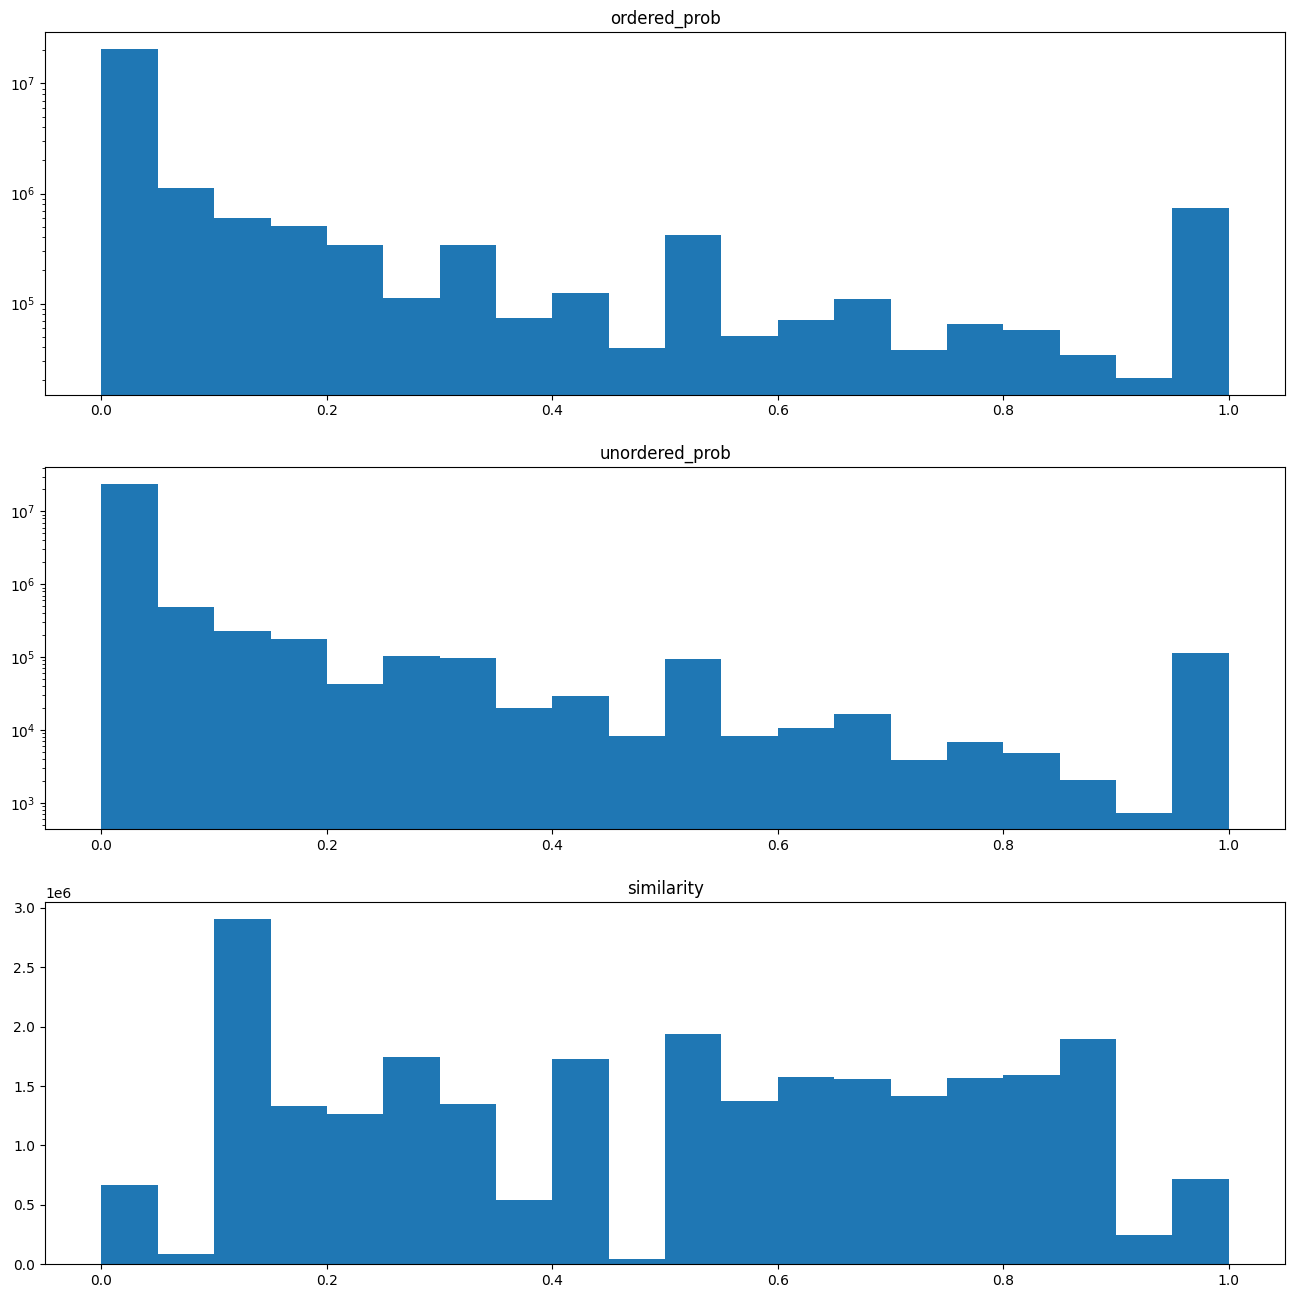

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 16))
axs[0].hist(df["ordered_prob"], bins=20, log=True)
axs[0].set_title("ordered_prob")
axs[1].hist(df["unordered_prob"], bins=20, log=True)
axs[1].set_title("unordered_prob")
axs[2].hist(df["similarity"], bins=20)
axs[2].set_title("similarity")

Text(0.5, 1.0, 'total_name_frequency')

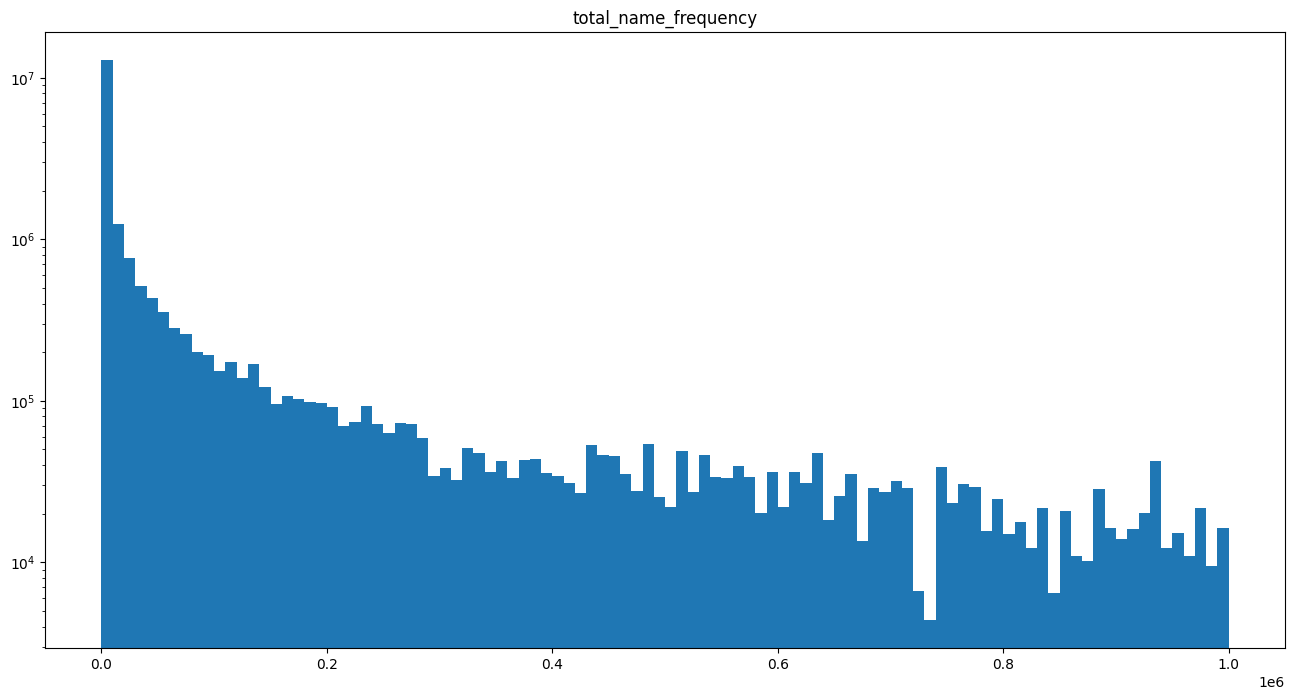

In [8]:
plt.figure(figsize=(16, 8))
plt.hist(df["total_name_frequency"], bins=100, range=(1, 1000000), log=True)
plt.title("total_name_frequency")

Text(0, 0.5, 'unordered_prob')

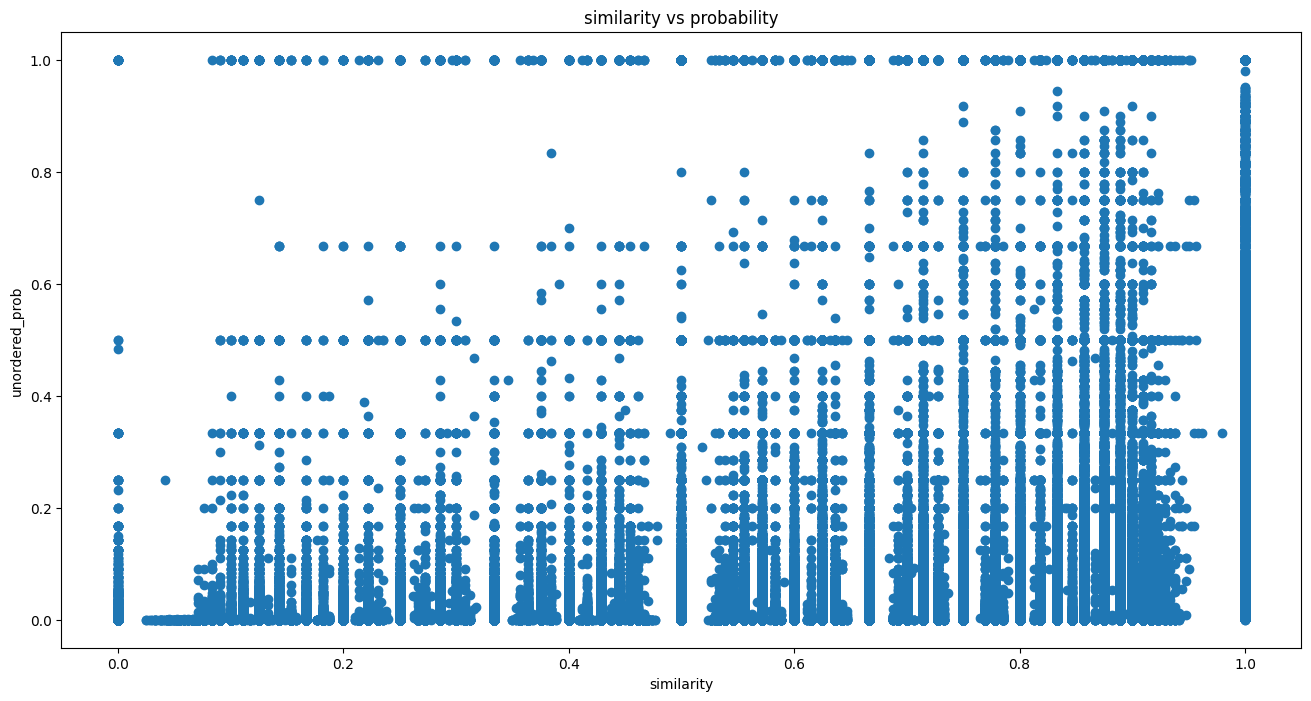

In [9]:
sample_df = df.sample(n=int(df.shape[0]*0.1))
plt.figure(figsize=(16, 8))
plt.scatter(x=sample_df["similarity"], y=sample_df["unordered_prob"])
plt.title("similarity vs probability")
plt.xlabel("similarity")
plt.ylabel("unordered_prob")

In [10]:
print(df.shape)

(25541154, 10)


In [11]:
# remove low similarity and low frequency
freq = df[(df["similarity"] > 0.4) & (df["frequency"] > 1)]
print(freq.shape)
freq.sample(n=25)

(5684975, 10)


,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
9848201,garrelts,garrette,2,0,791,1301,1541,0.002528,7.042253e-04,0.750000
17029161,martha,margrietha,9,4,5955276,10797887,9285,0.000002,1.202906e-06,0.600000
20758174,reinbolt,reinholt,3,5,18,58,7007,0.166667,1.133626e-03,0.875000
18350365,myrle,myal,6,0,40134,72028,264,0.000149,8.300362e-05,0.600000
17579629,medillia,madislia,2,0,62,64,2,0.032258,3.125000e-02,0.750000
1711106,antionette,anthonetha,2,0,24208,41784,135,0.000083,4.771334e-05,0.700000
14629108,lenora,elinore,21,20,348542,534998,28598,0.000060,7.275244e-05,0.571429
15494387,lourany,lourany,22,22,318,613,613,0.069182,3.722504e-02,1.000000
7724703,elser,elsner,8,0,306,876,523,0.026144,5.751258e-03,0.833333
25137400,wojiceck,wojiceck,2,2,3,6,6,0.666667,5.000000e-01,1.000000


In [12]:
# consider removing low-similarity, low-frequency, and low-probability pairs
low_sim_to_remove_indexes = (freq["similarity"] < 0.55) & ((freq["frequency"] < config.min_freq) | (freq["ordered_prob"] < .08))
low_sim_to_keep_indexes = (freq["similarity"] < 0.55) & ~((freq["frequency"] < config.min_freq) | (freq["ordered_prob"] < .08))
low_sim_to_remove = freq[low_sim_to_remove_indexes]
low_sim_to_keep = freq[low_sim_to_keep_indexes]

In [13]:
print(low_sim_to_remove.shape)
low_sim_to_remove.sample(n=25)

(887726, 10)


,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
19820381,pellegrina,pella,6,0,1157,1825,2395,5.185825e-03,1.423825e-03,0.500000
5459665,cornelis,kortekaas,2,0,224245,405028,3,8.918816e-06,4.937918e-06,0.444444
5015724,classie,clarry,2,0,2290,5454,3685,8.733625e-04,2.188902e-04,0.428571
4780988,christiana,cynthiana,2,0,378466,630933,1037,5.284491e-06,3.164717e-06,0.500000
13328548,juan,johoana,2,0,2075530,4200840,15,9.636093e-07,4.760938e-07,0.428571
5092571,clementina,valentine,2,2,65637,116704,434726,3.047062e-05,7.253920e-06,0.500000
16356893,mamie,mauris,11,5,688154,1404205,2298,1.598479e-05,1.137586e-05,0.500000
8311180,estalie,cidalise,4,0,68,125,765,5.882353e-02,4.514673e-03,0.500000
19634384,parthenia,tenie,25,0,32847,45316,6082,7.611045e-04,4.866369e-04,0.444444
3601138,branco,bernardo,2,5,773,3106,271922,2.587322e-03,2.545260e-05,0.500000


In [14]:
print(low_sim_to_keep.shape)
low_sim_to_keep.sample(n=50)

(33069, 10)


,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
16275170,majiec,mathias,8,0,9,9,1049265,0.888889,7.624377e-06,0.428571
9703095,fritzsimons,fritz,7,0,11,13,285466,0.636364,2.452079e-05,0.454545
13608832,kateleen,kate,14,2,44,134,2261356,0.318182,7.075032e-06,0.500000
24032916,vanith,van,7,0,8,10,374139,0.875000,1.870947e-05,0.500000
11550416,hetero,hettie,7,4,25,45,322234,0.280000,3.413308e-05,0.500000
15285664,lorenz,lawrence,10981,7817,118758,202436,3653127,0.092465,4.899440e-03,0.500000
19955313,petrii,peter,5,47,14,130,6593036,0.357143,7.887017e-06,0.500000
10116214,gerges,jorge,7,0,60,192,235724,0.116667,2.967246e-05,0.500000
8942685,fc,f,44,18,58,227,15827758,0.758621,3.917128e-06,0.500000
13514528,kacper,gaspar,285,0,2117,2237,92436,0.134624,3.019452e-03,0.500000


In [15]:
# remove noisy pairs as defined above
sim = freq[~low_sim_to_remove_indexes]
print(sim.shape)
# review suspicious pairs
print(sim[sim["similarity"] < 0.55].shape)
sim[sim["similarity"] < 0.55].sample(n=25)

(4797249, 10)
(33069, 10)


,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
14037379,laconna,connie,16,0,41,64,251763,0.390244,6.353972e-05,0.428571
4732039,chlory,flora,5,1,51,135,1958099,0.098039,3.063995e-06,0.500000
23437465,tiaremaori,tiare,7,0,7,7,231,1.000000,3.030303e-02,0.500000
12725600,jeanmary,jean,16,5,32,42,4329003,0.500000,4.850978e-06,0.500000
12058693,imbe,impi,8,8,26,57,3034,0.307692,5.203252e-03,0.500000
20632862,rayann,ray,7,5,46,105,3043452,0.152174,3.942770e-06,0.500000
5110819,cleni,clinton,5,0,35,68,1120236,0.142857,4.463094e-06,0.428571
25249184,yfania,hiphania,8,0,11,14,8,0.727273,5.714286e-01,0.500000
9932814,gelyds,gladys,5,0,5,5,3593760,1.000000,1.391300e-06,0.500000
10820849,gwan,gawn,6,3,68,175,775,0.088235,9.564294e-03,0.500000


In [16]:
# review dissimilar but frequent pairs
dis = df[
    (df["similarity"] <= 0.4) & ((df["frequency"] + df["reverse_frequency"]) >= 1000)
]
print(dis.shape)
dis.sample(n=25)

(27072, 10)


,name,alt_name,frequency,reverse_frequency,sum_name_frequency,total_name_frequency,total_alt_name_frequency,ordered_prob,unordered_prob,similarity
22007,a,ezra,40,1805,2578937,36295683,389989,0.000016,0.000050,0.250000
24455301,virginia,i,1117,35,3006801,4973076,3323763,0.000371,0.000139,0.125000
14007166,l,lees,73,2762,1756693,27387167,5665,0.000042,0.000104,0.250000
13124272,jolene,j,1233,27,6647,11493,31430971,0.185497,0.000040,0.166667
19518482,p,platt,146,10922,541160,8664490,23304,0.000270,0.001276,0.200000
20168765,pio,pioquinto,665,3910,33089,67676,35141,0.020097,0.046569,0.333333
21540634,s,sykes,71,3563,747216,11798028,6473,0.000095,0.000308,0.200000
12265465,isabel,elisa,861,376,1228465,2096926,497138,0.000701,0.000477,0.166667
15987207,m,mahon,27,1694,2669486,35476165,3545,0.000010,0.000049,0.200000
12538320,james,eugene,549,885,21846844,38521222,3409232,0.000025,0.000034,0.166667


In [17]:
# write similar and dissimilar pairs
save_file(config.similar_out_path,
          lambda local_out_path : sim.to_csv(local_out_path, index=False))

In [18]:
save_file(config.dissimilar_out_path,
          lambda local_out_path : dis.to_csv(local_out_path, index=False))